# LangGraph Agent Workflow Notes

---

## 1. State

- The **state** is the shared memory between agents.
- Stores conversation messages and routing information.
- Example:

```python
from typing import Annotated
from langgraph.state import MessagesState

class AgentState(MessagesState):
    next_agent: str  # Optional dynamic routing
Agents read & update state (messages, next_agent).

All changes are merged by the workflow.

2. Agent vs Workflow Graph
Agent next_agent
Each agent can suggest the next agent dynamically:

def planner_agent(state: AgentState):
    if "search" in state["messages"][-1]:
        return {"next_agent": "search"}
    else:
        return {"next_agent": "action"}
Workflow graph (StateGraph)
Defines allowed edges and execution order.

Blocks invalid routes and merges state.

Example dynamic branching:

from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_agent)
workflow.add_node("search", search_agent)
workflow.add_node("action", action_agent)

# Define allowed paths
workflow.add_edge("planner", "search")
workflow.add_edge("planner", "action")
workflow.add_edge("search", END)
workflow.add_edge("action", END)

final_workflow = workflow.compile()
Planner decides next_agent = "search" or "action" at runtime.

Graph ensures only valid nodes run.



In [3]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END,MessagesState
from langgraph.prebuilt import create_react_agent,ToolNode
from langgraph.checkpoint.memory import MemorySaver


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [4]:
class AgentState(MessagesState):
    next_agent: str

In [5]:
# Create simple tools
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Using Tavily for web search
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content: str) -> str:
    """Write a summary of the provided content."""
    # Simple summary generation
    summary = f"Summary of findings:\n\n{content[:500]}..."
    return summary

In [6]:
from langchain.chat_models import init_chat_model

llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000149617FE240>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000014961B76ED0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
# Define agent functions (simpler approach)
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    
    messages = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)
    
    # Return the response and route to writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    
    messages = state["messages"]
    
    # Add system message
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")

    llm_writer = llm.bind_tools([write_summary])
    
    # Simple completion without tools
    response = llm_writer.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [ ]:
# Tool executor node
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state

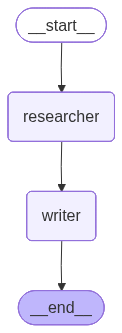

In [9]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [11]:
response=final_workflow.invoke({"messages":"Reasearch about the usecase of agentic ai in business"})

In [15]:
response['messages'][-1].content

' \n\nAfter conducting research on the web, I have compiled a summary of the use cases of agentic AI in business:\n\n**Summary:**\n\nAgentic AI refers to artificial intelligence that can take initiative, make decisions, and act autonomously in certain situations. The application of agentic AI in business is vast and rapidly growing, with several key use cases emerging:\n\n1. **Process Automation:** Agentic AI can automate repetitive and time-consuming tasks, freeing up human resources for more strategic and creative work. Examples include:\n\t* Data entry and processing\n\t* Customer service chatbots\n\t* Predictive maintenance and quality control\n2. **Decision Support:** Agentic AI can provide insights and recommendations to support business decision-making, such as:\n\t* Predictive analytics for sales forecasting and demand planning\n\t* Supply chain optimization and inventory management\n\t* Risk management and compliance monitoring\n3. **Customer Experience:** Agentic AI can creat

### supervise Multi Ai Agent Architecture

In [16]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [17]:
help(MessagesState)

Help on class MessagesState in module langgraph.graph.message:

class MessagesState(builtins.dict)
 |  Method resolution order:
 |      MessagesState
 |      builtins.dict
 |      builtins.object
 |
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object
 |
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |
 |  __annotations__ = {'messages': ForwardRef('Annotated[list[AnyMessage],...
 |
 |  __closed__ = None
 |
 |  __extra_items__ = typing_extensions.NoExtraItems
 |
 |  __mutable_keys__ = frozenset({'messages'})
 |
 |  __optional_keys__ = frozenset()
 |
 |  __orig_bases__ = (typing_extensions.TypedDict,)
 |
 |  __readonly_keys__ = frozenset()
 |
 |  __required_keys__ = frozenset({'messages'})
 |
 |  __total__ = True
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited f